In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

In [2]:
path_json_r = "./Data/clean_records/1/1RW298.json"
path_json_l = "./Data/clean_records/1/1LW152.json"
path_json_t = "./Data/clean_records/2/2TR151.json"
path_excel = "Data/Protocole standardisé_Annotations_BIN/Angers/04.01.01/04.01.01_MS_01.xlsx"

In [42]:
df_r = pd.read_json(path_json_r)
df_l = pd.read_json(path_json_l)
df_t = pd.read_json(path_json_t)

df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32038 entries, 0 to 32037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   accel_x    32038 non-null  float64
 1   accel_y    32038 non-null  float64
 2   accel_z    32038 non-null  float64
 3   gyro_x     32038 non-null  float64
 4   gyro_y     32038 non-null  float64
 5   gyro_z     32038 non-null  float64
 6   timestamp  32038 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB


In [4]:
df_r[(df_r["timestamp"] >= 0) & (df_r["timestamp"] <= 1)]

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,timestamp
0,0.010952,-0.208460,0.961739,2.581739,-4.261108,-0.463829,0.000000
1,0.005296,-0.220925,0.967791,2.375446,-2.133212,-1.021291,0.007812
2,-0.005525,-0.223369,0.970938,-2.128613,-0.856474,0.511730,0.015625
3,-0.009951,-0.224836,0.982558,-3.503898,2.122580,3.333883,0.023438
4,-0.024214,-0.223858,0.982558,-2.334906,2.512695,3.368724,0.031250
...,...,...,...,...,...,...,...
124,-0.030607,-0.224347,0.998536,2.272299,1.945256,-1.474230,0.968750
125,-0.031591,-0.230946,0.979169,1.515893,-0.785544,-1.369705,0.976562
126,-0.018804,-0.231190,0.963434,0.656339,-3.268090,-1.718119,0.984375
127,-0.027411,-0.230701,0.963192,0.243754,-1.494843,-1.648437,0.992188


In [5]:
df_r = df_r[["accel_x", "accel_y", "accel_z", "timestamp"]]
df_l = df_l[["accel_x", "accel_y", "accel_z", "timestamp"]]
df_t = df_t[["accel_x", "accel_y", "accel_z", "timestamp"]]

## Coefficients

In [6]:
frequence = 128
COEFF = 0.001664
threshold = 0.5

# Filtre

In [7]:
from scipy.signal import butter, ellip
from scipy import signal

N = 6
rp = 1
rs = 50

Fn = frequence/2;                                                  
Wp = np.divide([0.25, 2.5],Fn)

sos = ellip(N, rp, rs, Wp, btype='bandpass', analog=False, output='sos', fs=None)


## Capteur droit

In [8]:
filtd_rx = signal.sosfilt(sos, df_r["accel_x"])
filtd_ry = signal.sosfilt(sos, df_r["accel_y"])
filtd_rz = signal.sosfilt(sos, df_r["accel_z"])

In [9]:
df_filtrd_r = pd.DataFrame(list(zip(filtd_rx, filtd_ry, filtd_rz, df_r["timestamp"] )), columns =['accel_x', 'accel_y', 'accel_z', "timestamp" ])

## Capteur gauche 

In [10]:
filtd_lx = signal.sosfilt(sos, df_l["accel_x"])
filtd_ly = signal.sosfilt(sos, df_l["accel_y"])
filtd_lz = signal.sosfilt(sos, df_l["accel_z"])

In [11]:
df_filtrd_l = pd.DataFrame(list(zip(filtd_lx, filtd_ly, filtd_lz, df_r["timestamp"] )), columns =['accel_x', 'accel_y', 'accel_z', "timestamp" ])

## Capteur Thorax

In [12]:
filtd_tx = signal.sosfilt(sos, df_t["accel_x"])
filtd_ty = signal.sosfilt(sos, df_t["accel_y"])
filtd_tz = signal.sosfilt(sos, df_t["accel_z"])

In [13]:
df_filtrd_t = pd.DataFrame(list(zip(filtd_tx, filtd_ty, filtd_tz, df_r["timestamp"] )), columns =['accel_x', 'accel_y', 'accel_z', "timestamp" ])

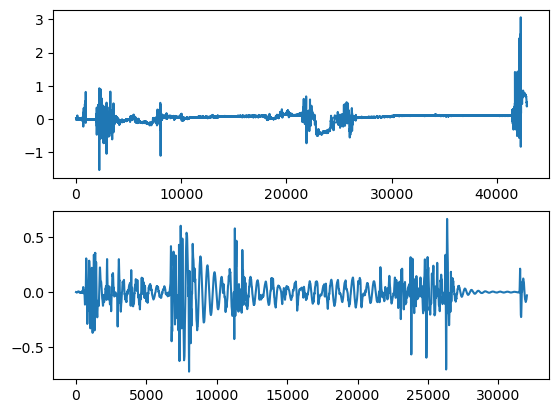

In [14]:
plt.subplot(2,1,1)
plt.plot(df_t["accel_x"])
plt.subplot(2,1,2)
plt.plot(filtd_rx)
plt.show()

## Activity Count

In [15]:
acs_r = np.zeros(int(len(df_filtrd_r)/frequence))
acs_l = np.zeros(int(len(df_filtrd_l)/frequence))
acs_t = np.zeros(int(len(df_filtrd_t)/frequence))

In [16]:
print(acs_r.shape)
print(acs_l.shape)
print(acs_t.shape)

(250,)
(250,)
(250,)


In [17]:
for i in range(acs_r.shape[0]):
    r = np.abs(df_filtrd_r[(df_filtrd_r["timestamp"] > i) & (df_filtrd_r["timestamp"] < i+1)].mean())/COEFF
    acs_r[i] = np.sqrt(np.square(r[["accel_x", "accel_y", "accel_z"]]).sum(axis=0))

#print(acs_r)
print(acs_r.mean())

73.12759479885837


In [18]:
for i in range(acs_l.shape[0]):
    l = np.abs(df_filtrd_l[(df_filtrd_l["timestamp"] > i) & (df_filtrd_l["timestamp"] < i+1)].mean())/COEFF
    acs_l[i] = np.sqrt(np.square(l[["accel_x", "accel_y", "accel_z"]]).sum(axis=0))

#print(acs_l)
print(acs_l.mean())

55.46318967411888


In [19]:
for i in range(acs_t.shape[0]):
    t = np.abs(df_filtrd_t[(df_filtrd_t["timestamp"] > i) & (df_filtrd_t["timestamp"] < i+1)].mean())/COEFF
    acs_t[i] = np.sqrt(np.square(t[["accel_x", "accel_y", "accel_z"]]).sum(axis=0))

#print(acs_t)
print(acs_t.mean())

23.248199450451445


In [20]:
time_r = np.linspace(0, len(acs_r), len(acs_r))
time_l = np.linspace(0, len(acs_l), len(acs_l))
time_t = np.linspace(0, len(acs_t), len(acs_t))

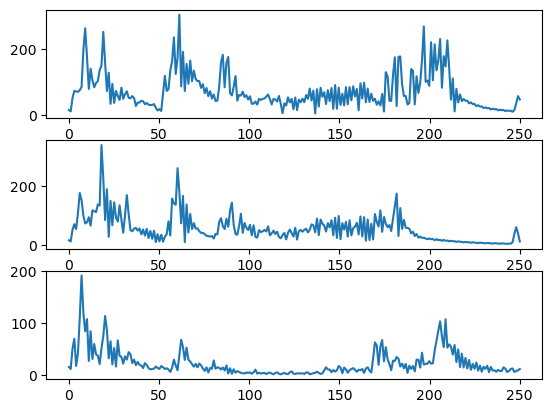

In [21]:
plt.subplot(3,1,1)
plt.plot(time_r, acs_r)
plt.subplot(3,1,2)
plt.plot(time_l, acs_l)
plt.subplot(3,1,3)
plt.plot(time_t, acs_t)
plt.show()


In [22]:
for i in range(2):
    print("start : " , i)
    print("end : ", i+1)
    r = np.abs((df_filtrd_r[(df_filtrd_r["timestamp"] > i) & (df_filtrd_r["timestamp"] < i+1)]).mean())
    print("moyennes : ")
    print(r)
    
    r = r /COEFF

    print(r) 
    
    acs_r[i] = np.sqrt(np.square(r[["accel_x", "accel_y", "accel_z"]]).sum(axis=0))
    
    print("AC : ", acs_r[i])
    
    print("###############")

print(acs_r[0])
print(acs_r[1])

start :  0
end :  1
moyennes : 
accel_x      0.000801
accel_y      0.005290
accel_z      0.024970
timestamp    0.500000
dtype: float64
accel_x        0.481487
accel_y        3.179051
accel_z       15.006010
timestamp    300.480769
dtype: float64
AC :  15.346613041256388
###############
start :  1
end :  2
moyennes : 
accel_x      0.002443
accel_y      0.003958
accel_z      0.017944
timestamp    1.500000
dtype: float64
accel_x        1.468278
accel_y        2.378531
accel_z       10.783433
timestamp    901.442308
dtype: float64
AC :  11.139823950265393
###############
15.346613041256388
11.139823950265393


# Données annotées

In [23]:
df_boha = pd.read_excel(path_excel)
df_boha

,Observation id,Observation date,Description,Media file,Total length,FPS,Subject,Behavior,Behavioral category,Modifiers,Behavior type,Start (s),Stop (s),Duration (s),Comment start,Comment stop
0,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,Start_RW,NaN,NaN,POINT,10.584,10.584,NaN,NaN,NaN
1,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,RW non noté,NaN,NaN,STATE,16.672,22.182,5.510,NaN,NaN
2,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,RW sédentaire,NaN,NaN,STATE,22.182,28.681,6.499,NaN,NaN
3,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,RW mouv IV FA,NaN,NaN,STATE,28.681,32.685,4.004,NaN,NaN
4,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,RW mouv IV GA,NaN,NaN,STATE,32.685,46.253,13.568,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,RW mouv IV GA,NaN,NaN,STATE,1573.948,1589.904,15.956,NaN,NaN
174,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,RW mouv V GA,NaN,NaN,STATE,1589.904,1600.151,10.247,NaN,NaN
175,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,RW mouv IV GA,NaN,NaN,STATE,1600.151,1618.721,18.570,NaN,NaN
176,04.01.01_Boha,2022-06-19 18:38:02,NaN,F:/mémoire/annotation vidéo/actimètrie_validit...,1625.28,25,04.01.01,LW mouv IV FA,NaN,NaN,STATE,1618.721,1624.718,5.997,NaN,NaN


In [24]:
etats_r = ["Start_RW", "RW non noté", "RW sédentaire", "RW mouv", "RW mouv IV FA", "RW mouv IV GA"]
etats_l = ["Start_LW", "LW non noté", "LW sédentaire", "LW mouv", "LW mouv IV FA", "LW mouv IV GA"]
etats_t = ["Start_Thorax", "Thorax non noté", "Thorax sédentaire", "Thorax mouv IV FA", "Thorax mouv IV GA"]

In [25]:
df_boha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Observation id       178 non-null    object 
 1   Observation date     178 non-null    object 
 2   Description          0 non-null      float64
 3   Media file           178 non-null    object 
 4   Total length         178 non-null    float64
 5   FPS                  178 non-null    int64  
 6   Subject              178 non-null    object 
 7   Behavior             178 non-null    object 
 8   Behavioral category  0 non-null      float64
 9   Modifiers            0 non-null      float64
 10  Behavior type        178 non-null    object 
 11  Start (s)            178 non-null    float64
 12  Stop (s)             178 non-null    float64
 13  Duration (s)         175 non-null    float64
 14  Comment start        0 non-null      float64
 15  Comment stop         0 non-null      flo

In [26]:
#df_boha = df_boha[df_boha["Behavior"].str.contains("mouv")]
sum(df_boha["Stop (s)"] - df_boha["Start (s)"])

3196.087999999999

In [27]:
df_boha_rw_mouv = df_boha[df_boha["Behavior"].str.contains(etats_r[3])]
sum(df_boha_rw_mouv["Stop (s)"] - df_boha_rw_mouv["Start (s)"])

1596.0370000000003

In [28]:
df_boha_lw_mouv = df_boha[df_boha["Behavior"].str.contains(etats_l[3])]
df_boha_lw_mouv = df_boha_lw_mouv[["Behavior", "Start (s)", "Stop (s)"]]

In [29]:
sum(df_boha_lw_mouv["Stop (s)"] - df_boha_lw_mouv["Start (s)"])

1554.8550000000002

In [30]:
threshold = 15

In [31]:
tps_biman = 0

for i in range(len(acs_l)):
    if i <= len(acs_r):
        if acs_l[i] > threshold and acs_r[i] > threshold :
            tps_biman += 1
print(tps_biman)

198


# Etats

In [32]:
df_filtrd_t

,accel_x,accel_y,accel_z,timestamp
0,0.000071,0.000547,0.003138,0.000000
1,0.000066,0.000582,0.003357,0.007812
2,0.000040,0.000700,0.004085,0.015625
3,0.000045,0.000916,0.005327,0.023438
4,0.000069,0.001216,0.007022,0.031250
...,...,...,...,...
32033,-0.003788,0.003766,0.018410,250.257812
32034,-0.003862,0.003660,0.018135,250.265625
32035,-0.003947,0.003558,0.017865,250.273438
32036,-0.004029,0.003442,0.017569,250.281250


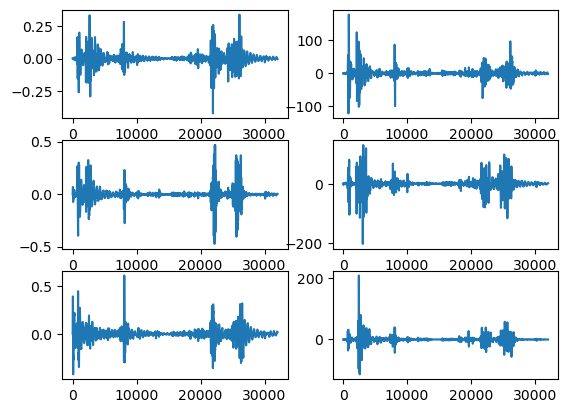

In [55]:
df_filtrd_t_range = df_filtrd_t[(df_filtrd_t["timestamp"]>3) & (df_filtrd_t["timestamp"]<138)]

df_t = pd.read_json(path_json_t)

filtd_tax = signal.sosfilt(sos, df_t["accel_x"])
filtd_tay = signal.sosfilt(sos, df_t["accel_y"])
filtd_taz = signal.sosfilt(sos, df_t["accel_z"])
filtd_tgx = signal.sosfilt(sos, df_t["gyro_x"])
filtd_tgy = signal.sosfilt(sos, df_t["gyro_y"])
filtd_tgz = signal.sosfilt(sos, df_t["gyro_z"])

df_filtrd_t = pd.DataFrame(list(zip(filtd_tax, filtd_tay, filtd_taz, filtd_tgx, filtd_tgy, filtd_tgz, df_r["timestamp"] )), columns =['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', "timestamp" ])

plt.subplot(3,2,1)
plt.plot(df_filtrd_t["accel_x"])
plt.subplot(3,2,2)
plt.plot(df_filtrd_t["gyro_x"])
plt.subplot(3,2,3)
plt.plot(df_filtrd_t["accel_y"])
plt.subplot(3,2,4)
plt.plot(df_filtrd_t["gyro_y"])
plt.subplot(3,2,5)
plt.plot(df_filtrd_t["accel_z"])
plt.subplot(3,2,6)
plt.plot(df_filtrd_t["gyro_z"])

## AC

In [52]:
acs_t = np.zeros(int(len(df_filtrd_t)/frequence))
time_t = np.linspace(0, len(acs_t), len(acs_t))

In [53]:
for i in range(acs_t.shape[0]):
    t = np.abs(df_filtrd_t[(df_filtrd_t["timestamp"] > i) & (df_filtrd_t["timestamp"] < i+1)].mean())/COEFF
    acs_t[i] = np.sqrt(np.square(t[["accel_x", "accel_y", "accel_z"]]).sum(axis=0))

#print(acs_t)
print(acs_t.mean())

23.248199450451445


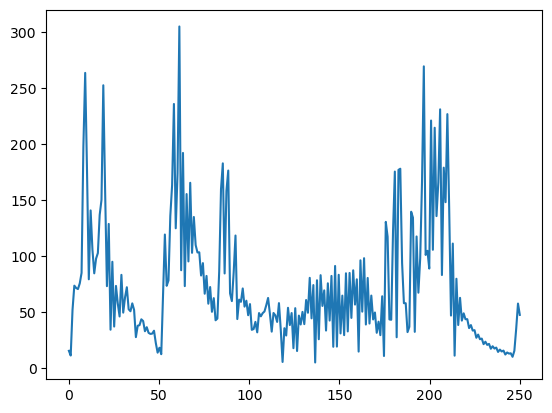

In [54]:
plt.plot(time_r, acs_r)

In [ ]:
### Assise entre 83 et 138

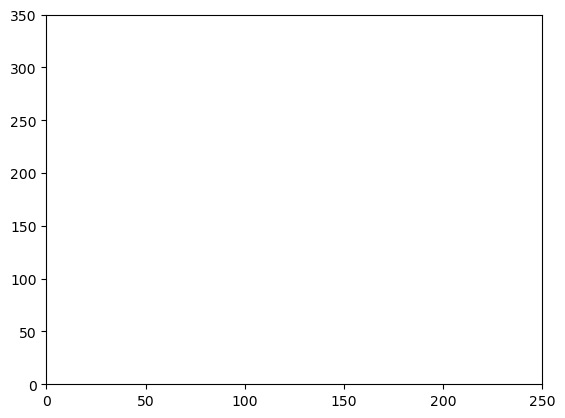

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 250), ylim=(0, 350))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = time_r
    y = acs_r
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
           frames=200, interval=20, blit=True)

plt.show()